In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Load Raw data from CSV files (data is split into user table, questionnaire table, motion table, sound table and location table)

In [3]:
users = pd.read_csv('data/USERS.csv')
qs = pd.read_csv('data/QUESTIONNAIRE.csv')
motion = pd.read_csv('data/MOTION.csv')
sound = pd.read_csv('data/SOUND.csv')
location = pd.read_csv('data/LOCATION.csv')

#### Data Collection App had 30 test users...we will exclude them from the analysis

In [4]:
users = users[users['userID'] >= 30]
qs = qs[qs['user'] >= 30]
motion = motion[motion['user'] >= 30]
sound = sound[sound['user']>= 30]
location = location[location['user'] >= 30]

#### Remove Questionnaire entries that do not have a valid Result1 and Result2 (Result1 and Result2 are the SF36 questionnaire summary values for Physical Component Score and Mental component scores. These are summary meeasure computed from the other 36 items. Result1 and Result2 are computed at the time of completing the questionnaire on the App)

In [5]:
qs = qs[(qs['Result1'] > 0) & (qs['Result2'] > 0)]

##### Validate that there are now no nulls in the questionnaire

In [6]:
qs.isna().sum().value_counts()

0    43
dtype: int64

#### Join Questionnaire with User (do a qs left join with users so that only users with valid questionnaire data are kept in the resulting join)

In [7]:
users = users.rename(columns={'userID':'user'})
joined = pd.merge(qs,users,on='user',how='left')

#### Check number of Males (==1) compared to females (==2)...-1 means user chose not to enter a value for this question

In [9]:
joined['Gender'].value_counts()

 2.0    1155
 1.0     970
-1.0      71
Name: Gender, dtype: int64

# Data Vizuaization of SF-36 Phyisical Component Score Dsitribution

<Figure size 720x1080 with 0 Axes>

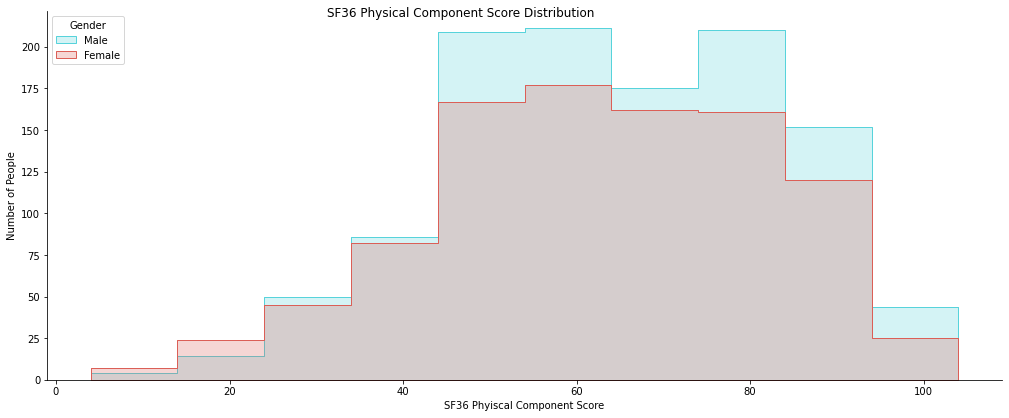

In [10]:
plt.figure(figsize=(10,15))
dist = sns.displot(joined[joined['Gender'] >= 1],x='Result1',hue='Gender',binwidth=10,element="step",palette=sns.color_palette("hls", 2),legend=False)
plt.legend(title='Gender',labels=['Male','Female'],loc='upper left')
dist.fig.suptitle('SF36 Physical Component Score Distribution')
dist.fig.set_figheight(6)
dist.fig.set_figwidth(16)
plt.xlabel('SF36 Phyiscal Component Score')
plt.ylabel('Number of People')
plt.show(dist)

In [11]:
print(f"Mean Physical Component Score for Males = {joined[joined['Gender'] == 1]['Result1'].mean()} (std= {joined[joined['Gender'] == 1]['Result1'].std()})")
print(f"Mean Physical Component Score for Females = {joined[joined['Gender'] == 2]['Result1'].mean()} (std= {joined[joined['Gender'] == 2]['Result1'].std()})")


Mean Physical Component Score for Males = 62.17422680412371 (std= 19.291462675683483)
Mean Physical Component Score for Females = 63.973160173160174 (std= 18.610533719051293)


# Data Vizuaization of SF-36 Mental Component Score Dsitribution

<Figure size 720x1080 with 0 Axes>

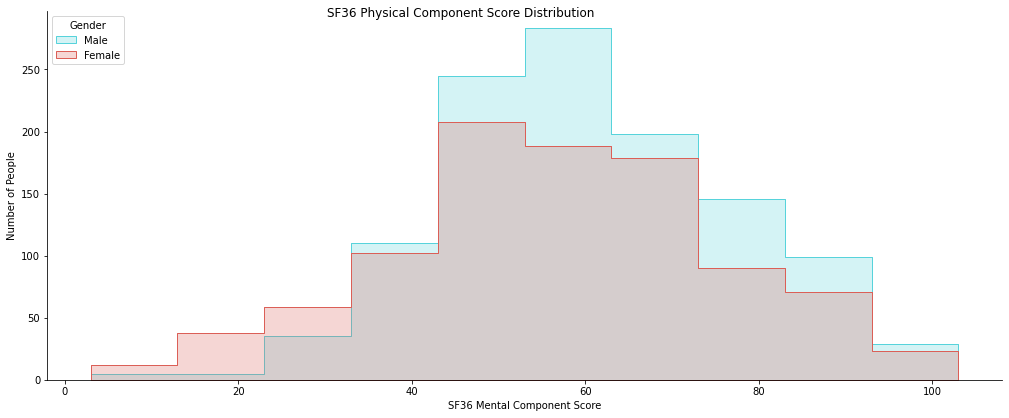

In [12]:
plt.figure(figsize=(10,15))
dist = sns.displot(joined[joined['Gender'] >= 1],x='Result2',hue='Gender',binwidth=10,element="step",palette=sns.color_palette("hls", 2),legend=False)
plt.legend(title='Gender',labels=['Male','Female'],loc='upper left')
dist.fig.suptitle('SF36 Physical Component Score Distribution')
dist.fig.set_figheight(6)
dist.fig.set_figwidth(16)
plt.xlabel('SF36 Mental Component Score')
plt.ylabel('Number of People')
plt.show(dist)

In [13]:
print(f"Mean Mental Component Score for Males = {joined[joined['Gender'] == 1]['Result2'].mean()} (std= {joined[joined['Gender'] == 1]['Result2'].std()})")
print(f"Mean Mental Component Score for Females = {joined[joined['Gender'] == 2]['Result2'].mean()} (std= {joined[joined['Gender'] == 2]['Result2'].std()})")


Mean Mental Component Score for Males = 56.05463917525773 (std= 19.02586648715125)
Mean Mental Component Score for Females = 59.96709956709957 (std= 16.51192389340671)


# Profile Of PCS by Age range

<Figure size 720x1080 with 0 Axes>

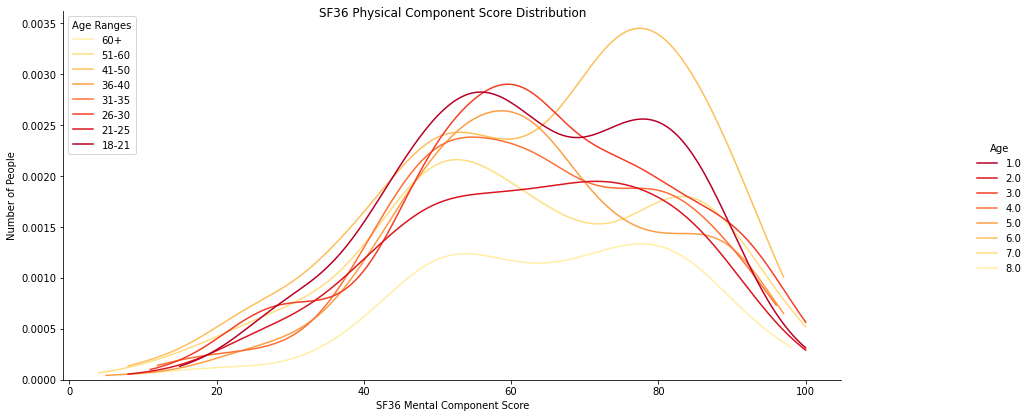

In [66]:
plt.figure(figsize=(10,15))
dist = sns.displot(joined[joined['Age'] >= 1],x='Result1',hue='Age',palette=sns.color_palette("YlOrRd_r", 8),kind='kde',cut=0,warn_singular=False)
plt.legend(title='Age Ranges',labels=['60+','51-60','41-50','36-40','31-35','26-30','21-25','18-21'],loc='upper left')
dist.fig.suptitle('SF36 Physical Component Score Distribution')
dist.fig.set_figheight(6)
dist.fig.set_figwidth(16)
plt.xlabel('SF36 Mental Component Score')
plt.ylabel('Number of People')
plt.show(dist)

# Analysis of PCS and MCS scores by Country

In [14]:
#group by countries and extract mean scores per country
countries = joined.groupby(by='countryID')[['Result1','Result2']].agg(['mean', 'count'])

In [15]:
#flatted the multiindex column names created by agg method
countries.columns = countries.columns.get_level_values(0) + '_' +  countries.columns.get_level_values(1)

In [16]:
#filter results so that we only analyse means of countires with at least 10 data points
MIN_NO_COUNTRY_ENTRIES = 10
countries = countries[countries[('Result1_count')] > MIN_NO_COUNTRY_ENTRIES]
countries = countries.sort_values(by='Result1_mean',ascending=False)
#countries['type'] = 'PCS'

In [230]:
#pull out copies of Result1 (pcs) and result2 (mcs), create a new column specifying the type of scoring (pcs or mcs)..
#and then stack the two dataframes on top of each other
joined_sub1 = joined[['user','countryID','Result1','Age','Gender']].copy()
joined_sub1['type'] = 'PCS'
joined_sub2 = joined[['user','countryID','Result2','Age','Gender']].copy()
joined_sub2['type'] = 'MCS'
joined_sub2.columns = joined_sub1.columns
joined_subConc = pd.concat([joined_sub1,joined_sub2])

In [17]:
#countries is a filtered dataframe only representing countires with over 10 datapoints
#do a left join on countryID so resulting dataframe will only have countries with over 10 datapoints
t = pd.merge(countries.reset_index()[['countryID']],joined_subConc,on='countryID',how='left')

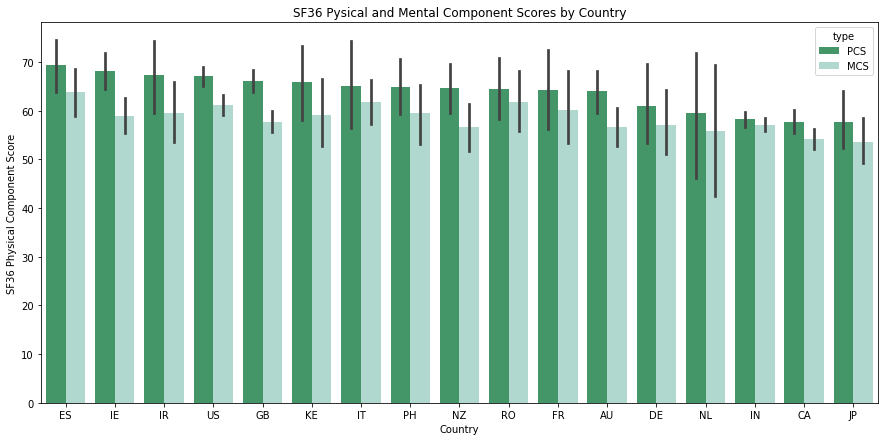

In [27]:
plt.figure(figsize=(15,7))

bar1 = sns.barplot(x='countryID',y='Result1',data=t,palette=sns.color_palette("BuGn_r", 2),hue='type')
bar1.set_title('SF36 Pysical and Mental Component Scores by Country')
plt.xlabel('Country')
plt.ylabel('SF36 Physical Component Score')
plt.show(bar1)